Преподаватель: В.И. Фирсанова

Курс "Компьютерная лингвистика" (НИУ ВШЭ СПб)

Сделан с любовью <3

### Скрипт для сбора НЕочищенных текстовых данных с веб-страницы

**Цель:** продемонстрировать типичный "сырой" материал, с которым работает NLP-специалист.

Полученные данные будут содержать **HTML-теги**, **лишние пробелы**, **спецсимволы** и другой **шум**.

**Задача:** научиться очищать тексты от **шума**, разобраться, почему **чистка данных** - важный этап предобработки текстов в NLP.

In [ ]:
# Импортируем необходимые библиотеки
import requests  # Для отправки HTTP-запросов и получения HTML-кода страницы
from bs4 import BeautifulSoup  # Для парсинга (разбора) HTML и извлечения нужных данных
import re  # Регулярные выражения

In [ ]:
def fetch_raw_html(url):
    """
    Функция получает сырой HTML-код с указанной веб-страницы.
    Эмулирует настоящего пользователя, чтобы некоторые сайты не блокировали запрос.

    Args:
        url (str): Адрес веб-страницы для парсинга.

    Returns:
        str: Необработанный HTML-код страницы или None в случае ошибки.
    """
    # Заголовки HTTP-запроса. Некоторые сайты требуют их присутствия, иначе блокируют скрипты.
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        # Отправляем GET-запрос на указанный URL с нашими заголовками
        response = requests.get(url, headers=headers)
        # Поднимаем исключение, если сервер вернул ошибку (код не 200)
        response.raise_for_status()
        # Возвращаем текстовое содержимое страницы в её оригинальной кодировке
        return response.text

    except requests.exceptions.RequestException as e:
        # Обрабатываем возможные ошибки: нет сети, сайт недоступен, и т.д.
        print(f"Ошибка при запросе к {url}: {e}")
        return None

In [ ]:
target_url = "https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%BF%D1%81" # Вставьте сюда URL страницы с текстом для парсинга
fetch_raw_html(target_url)

'<!DOCTYPE html>\n<html class="client-nojs" lang="ru" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Мопс — Википедия</title>\n<script>(function(){var className="client-js";var cookie=document.cookie.match(/(?:^|; )ruwikimwclientpreferences=([^;]+)/);if(cookie){cookie[1].split(\'%2C\').forEach(function(pref){className=className.replace(new RegExp(\'(^| )\'+pref.replace(/-clientpref-\\w+$|[^\\w-]+/g,\'\')+\'-clientpref-\\\\w+( |$)\'),\'$1\'+pref+\'$2\');});}document.documentElement.className=className;}());RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":[",\\t.","\xa0\\t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","январь","февраль","март","апрель","май","июнь","июль","август","сентябрь","октябрь","ноябрь","декабрь"],"wgRequestId":"931506ba-045d-4c02-8383-f73918ff532e","wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Мопс","wgTitle":"Мопс","wgCurRevisionId":146212844,"wgRevisionId":146212

> Продвинутый материал по работе с библиотекой requests, обход ограничений с помощью Session, headers, timeout, куки, а также использование API-токенов и параметров запроса: https://sky.pro/wiki/python/rabota-s-http-zagolovkami-v-python-primer-s-requests/



In [ ]:
def extract_dirty_text(html):
    """
    Функция извлекает текст из HTML, но делает это "грязно", сохраняя много лишнего.
    Это моделирует ситуацию, когда разработчик торопится или использует простой метод.

    Args:
        html (str): Строка с HTML-кодом.

    Returns:
        str: "Грязный" текст, извлеченный со страницы.
    """
    if not html:
        return "Не удалось получить HTML для парсинга."

    # Создаем объект BeautifulSoup для парсинга HTML. 'html.parser' - встроенный парсер Python.
    soup = BeautifulSoup(html, 'html.parser')

    # УДАЛЯЕМ явные элементы, которые нам точно не нужны (скрипты, стили) - это единственная чистка.
    for unwanted_tag in soup(['script', 'style', 'meta', 'link']):
        unwanted_tag.decompose()  # Полностью удаляем эти теги из дерева

    # !!! ВАЖНО: Мы НЕ будем аккуратно выбирать конкретный блок с текстом (например, 'article').
    # Вместо этого мы просто заберем ВЕСЬ текст со страницы, включая текст из меню, футера, рекламы и т.д.
    raw_text = soup.get_text()

    # Плохая практика №1: Неаккуратная замена переносов строк на пробелы.
    dirty_text = raw_text.replace('\n', '   ')  # Три пробела вместо одного

    # Плохая практика №2: Использование простого split и join для "нормализации" пробелов.
    # Это ломает пунктуацию и сливает слова с числами/знаками.
    dirty_text = ' '.join(dirty_text.split())

    # На этом этапе у нас уже достаточно "грязи", но давайте добавим ещё немного.

    # Плохая практика №3: Мы не будем обрабатывать неразрывные пробелы (&nbsp;) и другие HTML-сущности.
    # BeautifulSoup делает это по умолчанию, но давайте представим, что мы их не тронули.
    # Для наглядности добавим их искусственно в вывод (это сценарий "что если").
    dirty_text += " Здесь могла&nbsp;быть ваша реклама&copy;."

    # Плохая практика №4: Мы оставим обрывки URL или другого мусора, который не был в тегах <script>.
    # Для демонстрации добавим какой-нибудь случайный мусор.
    dirty_text += " !!!Important!!! Check this out: https://dodgy-site.com/buy-stuff-now !!!"

    return dirty_text

In [ ]:
extract_dirty_text(fetch_raw_html('https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%BF%D1%81'))[-1024:]

'pañolEestiفارسیSuomiFrançaisGaeilgeעבריתहिन्दीMagyarՀայերենBahasa IndonesiaIdoItaliano日本語ქართულიಕನ್ನಡ한국어LietuviųLatviešuМакедонскиBahasa MelayuNederlandsNorsk nynorskNorsk bokmålଓଡ଼ିଆਪੰਜਾਬੀPolskiپنجابیPortuguêsRomânăසිංහලSimple EnglishSlovenčinaSlovenščinaСрпски / srpskiSvenskaKiswahiliதமிழ்తెలుగుไทยTürkçeУкраїнськаTiếng Việt中文粵語 Править ссылки Эта страница в последний раз была отредактирована 16 июля 2025 года в 10:21. Текст доступен по лицензии Creative Commons «С указанием авторства — С сохранением условий» (CC BY-SA); в отдельных случаях могут действовать дополнительные условия. Подробнее см. Условия использования. Wikipedia® — зарегистрированный товарный знак некоммерческой организации «Фонд Викимедиа» (Wikimedia Foundation, Inc.) Политика конфиденциальности Описание Википедии Отказ от ответственности Свяжитесь с нами Кодекс поведения Разработчики Статистика Заявление о куки Мобильная версия Здесь могла&nbsp;быть ваша реклама&copy;. !!!Important!!! Check this out: https://dodgy-s

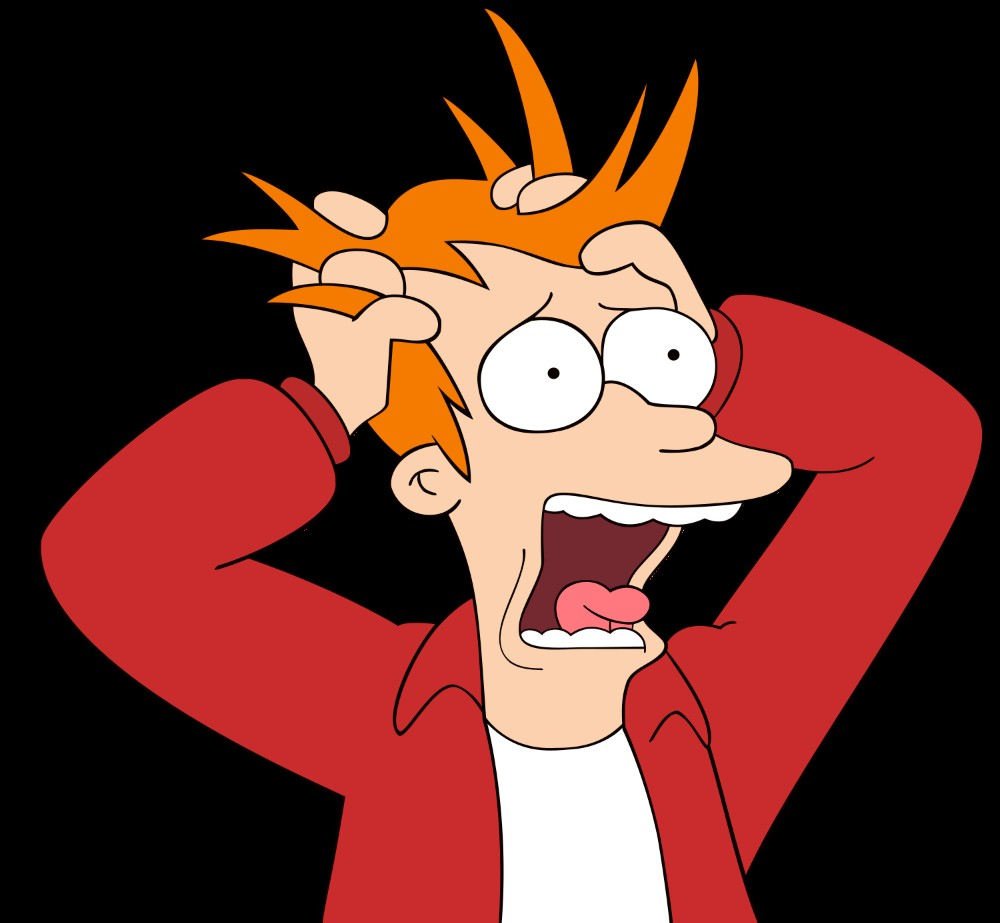

#### Ваша задача

In [ ]:
if __name__ == '__main__':
    # Выбираем URL для парсинга
    target_url = 'https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%BF%D1%81' # Введите сюда URL

    # 1. Получаем сырой HTML
    raw_html = fetch_raw_html(target_url)

    if raw_html:
        # 2. Извлекаем текст "грязным" способом
        dirty_data = extract_dirty_text(raw_html)

        # 3. Выводим результат (первые 1000 символов и последние 1000 символов)
        # Ваш код здесь:
        # - выводим первые 1000 символов и последние 1000 символов
        print("=" * 40 + "    НАЧАЛО ВЫВОДА    " + "=" * 40)
        print(dirty_data[:1000])
        print('\n')
        print('*'*100)
        print(dirty_data[-1000:])
        # - разделите две части вывода с помощью \n и последовательности '*'
        # - см. образец вывода в этой ячейке
        print("=" * 40 + "    КОНЕЦ ВЫВОДА    " + "=" * 40)

        # 4. Напишите в комментариях, какую "грязь" вы обнаружили
        # Ваш ответ здесь

    else:
        print("Не удалось получить данные для обработки. Проверьте URL или подключение к интернету.")

========================================    НАЧАЛО ВЫВОДА    ========================================
Мопс — Википедия Мопс Материал из Википедии — свободной энциклопедии Текущая версия страницы пока не проверялась опытными участниками и может значительно отличаться от версии, проверенной 31 декабря 2023 года; проверки требуют 24 правки. Перейти к навигации Перейти к поиску У этого термина существуют и другие значения, см. Мопс (значения). В другом языковом разделе есть более полная статья Pug (англ.). Вы можете помочь проекту, расширив текущую статью с помощью перевода Мопс Происхождение Место Древний Китай[1] Характеристики Рост 28—32 см[2] Масса 6,3—8,1 кг Шерсть гладкая Окрас абрикосовый, серебристый, бежевый и чёрный Срок жизни 13—15 лет Прочее Использование собака-компаньон Классификация МКФ Группа 9. Декоративные и собаки-компаньоны Секция 11. Малые молоссоиды Номер 253 Год 1966 Под патронатом Великобритания Другие классификации Группа КС Toy Группа АКС Toy Год АКС 1885 Медиафай

### Учебный материал: Регулярные выражения для чистки текста

**Регулярные выражения (Regular Expressions, regex)** — это инструмент для создания шаблонов (паттернов) для поиска и обработки текста по шаблонам.

Мы как бы кодируем паттерны с помощью специального языка (языка регулярных выражений), который описывает правила для поиска последовательностей символов, которые удовлетворяют этим правилам.

Пример: `r'\s+'` означает ищи все повторяющиеся пробелы (например, двойные или тройные пробелы). В NLP мы используем такие правила для очистки текста от "шума".

А где в выражении `r'\s+'` пробелы?! Сейчас разберемся.

#### Шпаргалка

| Символ | Что означает                                                                 | Пример       | Найдет                                                              |
| :---------------- | :------------------------------------------------------------------------------- | :--------------- | :---------------------------------------------------------------------- |
| `\d`              | Любая **цифра**                                                                  | `\d`             | `1`, `5`                                                                |
| `\w`              | Любой **символ слова** (буква, цифра, знак подчеркивания `_`)                    | `\w`             | `a`, `B`, `5`, `_`                                                      |
| `\s`              | Любой **пробельный символ** (пробел, табуляция `\t`, перенос строки `\n`)        | `\s`             | ` `, `\t`                                                               |
| `.`               | **Любой один** символ (кроме переноса строки)                                    | `a.c`            | `abc`, `a c`, `a-c`                                                     |
| `[abc]`           | Любой **один символ** из тех, что в скобках                                      | `[абв]`          | `а`, `б`, `в`                                                           |
| `[a-z]`           | Любой символ из **диапазона** (латиница, нижний регистр)                         | `[a-z]`          | `a`, `b`, `z` (но не `A` или `5`)                                       |
| `[^abc]`          | Любой символ, **кроме** тех, что в скобках                                       | `[^0-9]`         | `a`, `!`, ` ` (но не `1`, `2`)                                          |
| `*`               **Квантификаторы** **Квантификаторы** | **0 или более** повторений предыдущего символа/группы                            | `a*`             | `''` (пустая строка), `a`, `aa`, `aaa`                                  |
| `+`               | **1 или более** повторений предыдущего символа/группы                            | `\d+`            | `1`, `123`                                                              |
| `?`               | **0 или 1** повторение предыдущего символа/группы ("необязательный элемент")     | `https?`         | `http`, `https`                                                         |
| `{n}`             | **Ровно n** повторений                                                           | `\w{3}`          | `cat`, `a_1`, `123`                                                     |
| `^`               | **Начало** строки                                                                | `^Hello`         | `Hello world` (но не `Say Hello`)                                       |
| `$`               | **Конец** строки                                                                 | `world$`         | `Hello world` (но не `world peace`)                                     |
| `\|`               | **ИЛИ** (альтернатива)                                                           | `cat|dog`        | `cat`, `dog`                                                            |
| `()`              | **Группа** (позволяет объединить символы и применить к ним квантификатор)        | `(abc)+`         | `abc`, `abcabc`                                                         |



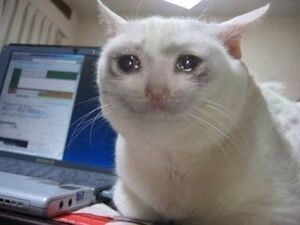

### 5-минутные упражнения

Начнём с готовых примеров и посмотрим, как оно рабоатет.

1. Удаление HTML-тегов

In [ ]:
# Паттерн: r'<[^>]+>'
text = "Текст с <b>тегами</b> и <br> переносами"
import re
cleaned = re.sub(r'<[^>]+>', '', text)
cleaned

'Текст с тегами и  переносами'

2. Удаление URL-адресов

In [ ]:
# Паттерн: r'https?://\S+'
text = "Сайт https://example.com и http://site.ru"
import re
cleaned = re.sub(r'https?://\S+', '', text)
cleaned

'Сайт  и '

3. Удаление email-адресов

In [ ]:
# Паттерн: r'\S+@\S+\.\S+'
text = "Пишите на email@example.com или support@mail.ru"
import re
cleaned = re.sub(r'\S+@\S+\.\S+', '', text)
cleaned

'Пишите на  или '

4. Удаление лишних символов

In [ ]:
# Паттерн: r'[^a-zA-Zа-яА-ЯёЁ0-9\s.,!?;:()-]'
text = "Важный текст! #метка @user $100"
import re
cleaned = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s.,!?;:()-]', '', text)
cleaned

'Важный текст! метка user 100'

5. Исправление пробелов

In [ ]:
# Паттерн: r'\s+'
text = "Много    лишних   пробелов\nи переносов"
import re
cleaned = re.sub(r'\s+', ' ', text)
cleaned

'Много лишних пробелов и переносов'

6. Поиск совпадений для паттерна

In [ ]:
text = "У меня 5 яблок и 3 груши"
import re
# Ищем все цифры
numbers = re.findall(r'\d', text)
numbers

['5', '3']

Упражнение 1: Замени все HTML-теги в строке на знак "[ТЕГ]"

In [ ]:
test_string = "Сообщение <div>с важным</div> тегом <img src='pic.jpg'>"
# Ваш код здесь:
import re
result = re.sub(r'<[^>]+>', '[ТЕГ]', test_string)
print(result)

Сообщение [ТЕГ]с важным[ТЕГ] тегом [ТЕГ]


Упражнение 2: Замени все URL на слово "[ССЫЛКА]"

In [ ]:
test_string = "Переходите на https://mysite.com и http://shop.ru"
# Ваш код здесь:
import re
result = re.sub(r'https?://\S+', '[ССЫЛКА]', test_string)
print(result)

Переходите на [ССЫЛКА] и [ССЫЛКА]


Упражнение 3: Найди и верни только email из строки

In [ ]:
test_string = "Контакты: info@company.com, тел: 89151234567"
# Ваш код здесь:
import re
emails = re.findall(r'\S+@\S+\.\S+', test_string)
print(emails)

['info@company.com,']


Упражнение 4: Удали все цифры и специальные символы, оставив только буквы и пробелы

In [ ]:
test_string = "Python 3.10 - это круто! #программирование"
# Ваш код здесь:
import re
result = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', test_string)
print(result)

Python   это круто программирование


Упражннение 5: Замени все последовательности пробелов и переносов на один пробел

In [ ]:
test_string = "Текст   с\nмножеством    пробелов\t\tи табов"
# Ваш код здесь:
import re
result = re.sub(r'\s+', '', test_string)
print(result)

Текст с множеством пробелов и табов


Упражнение 6: Комплексная очистка текста

In [ ]:
text = "Пишите на <b>email@example.com</b> или звоните +7-900-100-20-30    \n\nСайт: https://mysite.com"

# Цель: получить чистый текст без тегов, email, ссылок и лишних пробелов
import re
cleaned_text = re.sub(r'<[^>]+>', '', text) # Ваш код здесь: Удаляем теги
cleaned_text = re.sub(r'\S+@\S+\.\S+', '', cleaned_text) # Ваш код здесь: Удаляем email
cleaned_text = re.sub(r'https?://\S+', '', cleaned_text) # Ваш код здесь: Удаляем URL
cleaned_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s.,!?;:()-]', '', cleaned_text) # Ваш код здесь: Удаляем спецсимволы
cleaned_text = re.sub(r'\s+', '', cleaned_text) # Ваш код здесь: Заменяем последовательности пробелов одним

print(cleaned_text.strip())

Пишитенаилизвоните7-900-100-20-30Сайт:


### Домашка

Написать скрипт для выгрузки статьи про препроцессинг данных в NLP с сайта Medium и их очистки для дальнейшего NLP-анализа.

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

def get_page_text(url):
    """
    Получает HTML-код страницы и возвращает весь текст
    """
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Ошибка: {e}")
        return None

def clean_text(dirty_text):
    """
    Очищает текст от HTML-тегов и мусора
    """
    # Парсим HTML
    soup = BeautifulSoup(dirty_text, 'html.parser')
    # Удаляем ненужные элементы
    for element in soup(["script", "style", "meta", "link", "nav", "header", "footer"]):
        element.decompose()
    # Получаем чистый текст
    text = soup.get_text()
    # Удаляем URL-адреса
    text = re.sub(r'http\S+', '', text)
    # Удаляем email-адреса
    text = re.sub(r'\S+@\S+', '', text)
    # Оставляем только буквы, цифры, пробелы и основные знаки препинания
    text = re.sub(r'[^\w\s\.\,\!\?\-\:\(\)\'\"]', ' ', text)
    # Заменяем множественные пробелы на одинарные
    text = re.sub(r'\s+', ' ', text)
    # Удаляем пробелы в начале и конце
    text = text.strip()

    return text

def save_to_file(text, filename):
    """
    Сохраняет текст в файл
    """
    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(text)
        return True
    except Exception as e:
        print(f"Ошибка сохранения: {e}")
        return False

def main():
    url = "https://medium.com/data-science/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f"
    # Получаем страницу
    dirty_text = get_page_text(url)
    if not dirty_text:
        print("Не удалось загрузить страницу")
        return
    # Очищаем текст
    cleaned_text = clean_text(dirty_text)
    # Показываем результат
    print("=== ОРИГИНАЛЬНЫЙ ТЕКСТ (первые 500 символов) ===")
    print(dirty_text[:500])
    print("\n" + "="*50)

    print("=== ОЧИЩЕННЫЙ ТЕКСТ (первые 500 символов) ===")
    print(cleaned_text[:500])
    print("\n" + "="*50)
    # Сохраняем в файл
    if save_to_file(cleaned_text, "cleaned_python.txt"):
        print("Текст успешно сохранен в файл cleaned_python.txt")
    else:
        print("Ошибка при сохранении файла")

if __name__ == "__main__":
    main()

=== ОРИГИНАЛЬНЫЙ ТЕКСТ (первые 500 символов) ===
<!doctype html><html lang="en"><head><title data-rh="true">NLP for Beginners: Cleaning &amp; Preprocessing Text Data | by Rachel Koenig | TDS Archive | Medium</title><meta data-rh="true" charset="utf-8"/><meta data-rh="true" name="viewport" content="width=device-width,minimum-scale=1,initial-scale=1,maximum-scale=1"/><meta data-rh="true" name="theme-color" content="#000000"/><meta data-rh="true" name="twitter:app:name:iphone" content="Medium"/><meta data-rh="true" name="twitter:app:id:iphone" co

=== ОЧИЩЕННЫЙ ТЕКСТ (первые 500 символов) ===
NLP for Beginners: Cleaning Preprocessing Text Data by Rachel Koenig TDS Archive MediumSitemapOpen in appSign upSign inMedium LogoWriteSearchSign upSign inTDS Archive An archive of data science, data analytics, data engineering, machine learning, and artificial intelligence writing from the former Towards Data Science Medium publication.Press enter or click to view image in full sizeNLP for Beginners

Критерии оценивания:

1. Скрипт запускается без ошибок (1 балл)
2. Текст загружается с веб-страницы (1 балл)
3. Удалены HTML-теги (1 балл)
4. Удалены лишние пробелы и переносы (1 балл)
5. Реализовано сохранение текста в файл .txt (1 балл)
6. Использованы заголовки headers (1 балл)
7. Выполнена проверка HTTP-ответа (1 балл)
8. Выполнена обработка ошибок при загрузке веб-страницы (1 балл)
9. Выполнено удаление лишних элементов ('script', 'meta', 'link', 'footer', 'nav', 'header') (1 балл)
10. Код откомментирован (1 балл)